In [1]:
import numpy as np
import scipy as sp
import sklearn as skl
import skimage as ski
import os
from glob import glob
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

In [4]:
dataset = Path("Y:/kau/диплом/data/dataset")
workdir = Path("Y:/kau/диплом/data/run03")

os.makedirs(workdir, exist_ok=True)

In [5]:
descriptors = list(dataset.glob("hist_*.npy"))
descriptors

[WindowsPath('Y:/kau/диплом/data/dataset/hist_R1_P8_d.npy'),
 WindowsPath('Y:/kau/диплом/data/dataset/hist_R1_P8_u.npy'),
 WindowsPath('Y:/kau/диплом/data/dataset/hist_R2_P12_d.npy'),
 WindowsPath('Y:/kau/диплом/data/dataset/hist_R2_P12_u.npy'),
 WindowsPath('Y:/kau/диплом/data/dataset/hist_R3_P24_u.npy'),
 WindowsPath('Y:/kau/диплом/data/dataset/hist_R5_P36_u.npy')]

In [6]:
descriptor = 'hist_R2_P12_u'

In [7]:
chunksize = 100

In [105]:
y = np.load(f"{dataset}/labels.npy")
print(y.shape, y.dtype)
label = y[:,1]
label_subset = y[:,0]

(1950, 2) uint8


# Descriptor hist_R2_P12_u

## 1. Mean

In [106]:
X = np.load(f"{dataset}/{descriptor}.npy")
X.shape, X.dtype

((1950, 14), dtype('uint32'))

In [107]:
unique_labels, label_sizes = np.unique(label, return_counts=True)
nlabels = len(unique_labels)
unique_labels, label_sizes, nlabels

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13], dtype=uint8),
 array([150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150]),
 13)

features stratified by class/label

In [108]:
X_cl = np.array([ X[label == k] for k in unique_labels ])
X_cl.shape, X_cl.dtype

((13, 150, 14), dtype('uint32'))

mean histogram for each class

In [109]:
means = X_cl.mean(axis=1)
means.shape, means.dtype

((13, 14), dtype('float64'))

In [110]:
means[:,-1]

array([2737.86      , 3180.98      , 3303.97333333, 3690.46      ,
       3382.1       , 3460.46      , 3513.21333333, 4596.79333333,
       4295.65333333, 3579.36      , 3632.68666667, 4217.97333333,
       3626.44666667])

In [13]:
np.save(workdir / 'X_cl.npy', X_cl)
np.save(workdir / 'means.npy', means)

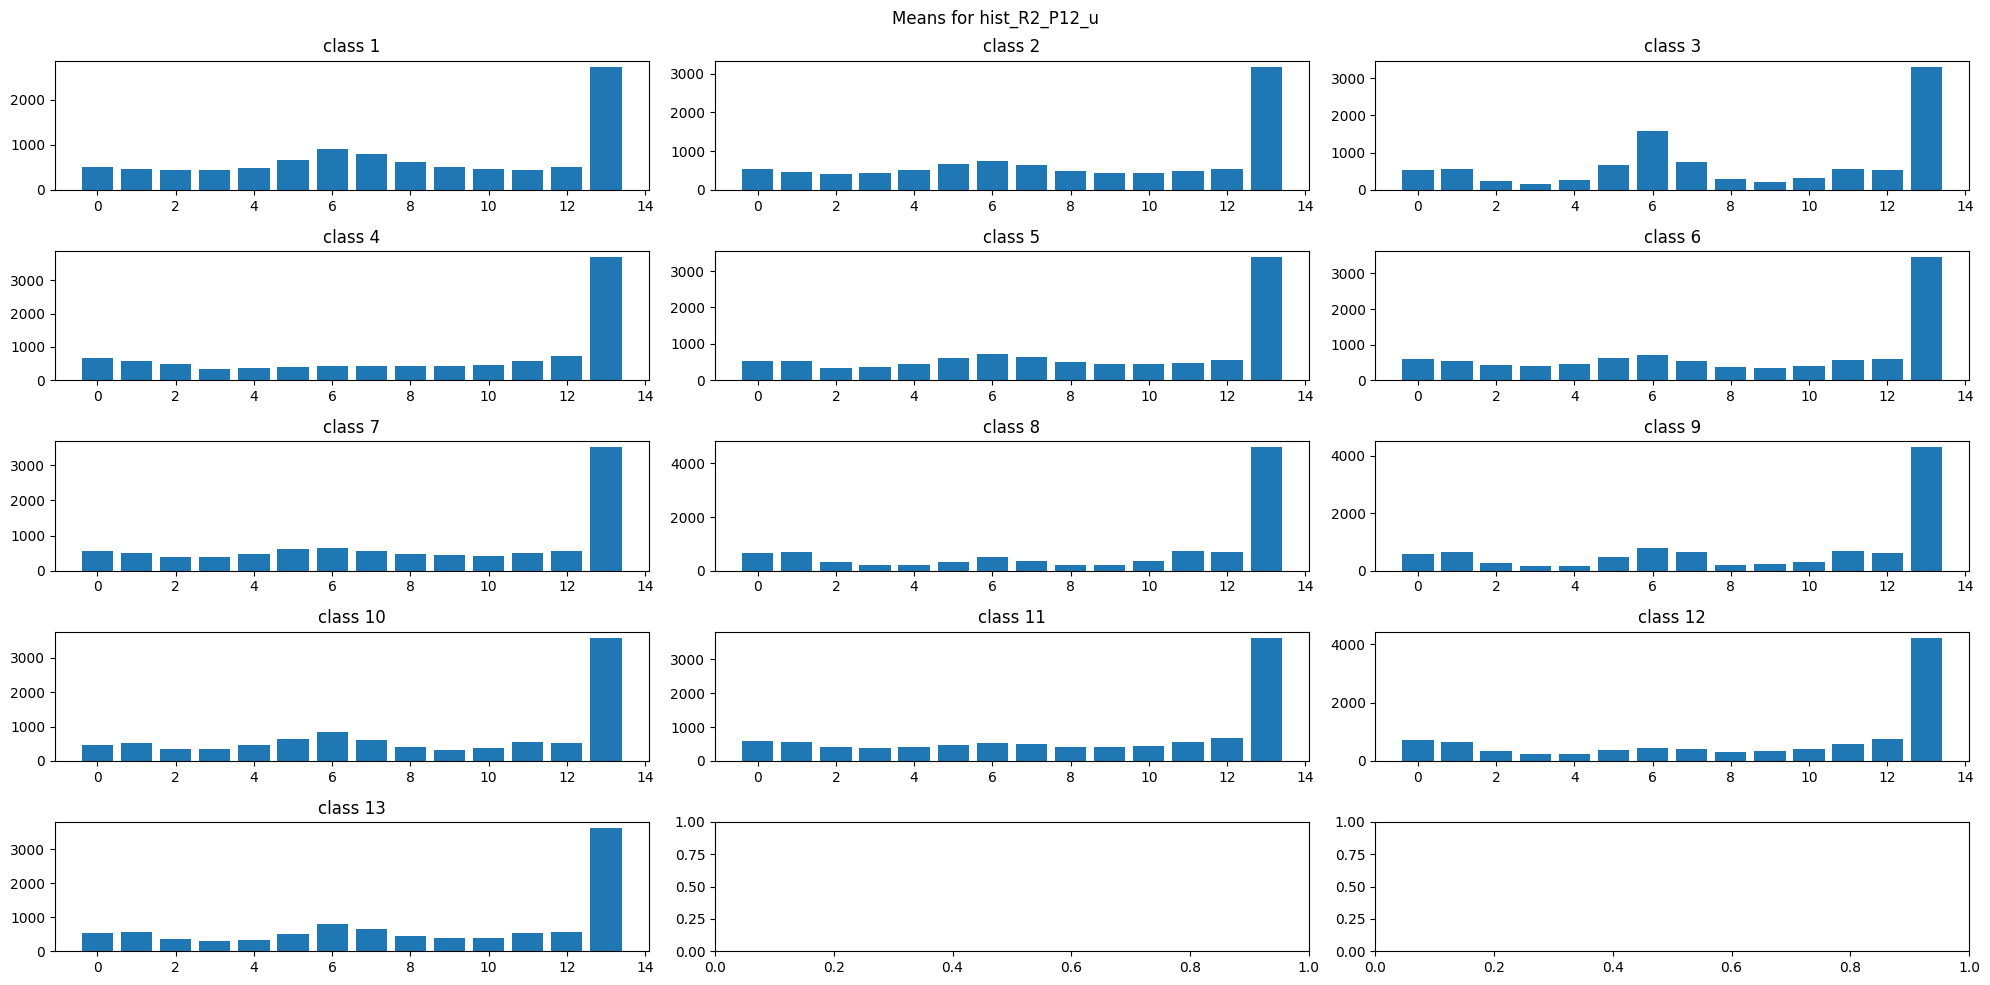

In [111]:
fig, axs = plt.subplots(5, 3)
for k in range(13):
    ax = axs.flat[k]
    ax.bar(range(means.shape[1]), means[k])
    ax.set_title(f'class {k+1}')
for k in range(13,len(axs)):
    axs.flat[k].set_axis_off()
fig.suptitle(f'Means for {descriptor}')
fig.set_size_inches((20,10))
fig.tight_layout()

### Some descriptive stats for mean histograms

In [112]:
print("Min:", means.min(axis=1))
print("Max:", means.max(axis=1))
print("Sum:", means.sum(axis=1))

Min: [440.56       412.74       168.05333333 349.55333333 349.44666667
 339.92       376.29333333 190.50666667 164.34666667 329.46666667
 386.94       244.74       296.66666667]
Max: [2737.86       3180.98       3303.97333333 3690.46       3382.1
 3460.46       3513.21333333 4596.79333333 4295.65333333 3579.36
 3632.68666667 4217.97333333 3626.44666667]
Sum: [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000.]


### CDF

In [113]:
means_cdf = means.cumsum(axis=1) / (chunksize**2)

# Sanity check -- this is a histogram and P = 1.0 for last item
assert (np.abs(means_cdf[:,-1] - 1) < 1e-5).all()

means_cdf.shape, means_cdf.dtype, means_cdf.max()

((13, 14), dtype('float64'), np.float64(1.0000000000000002))

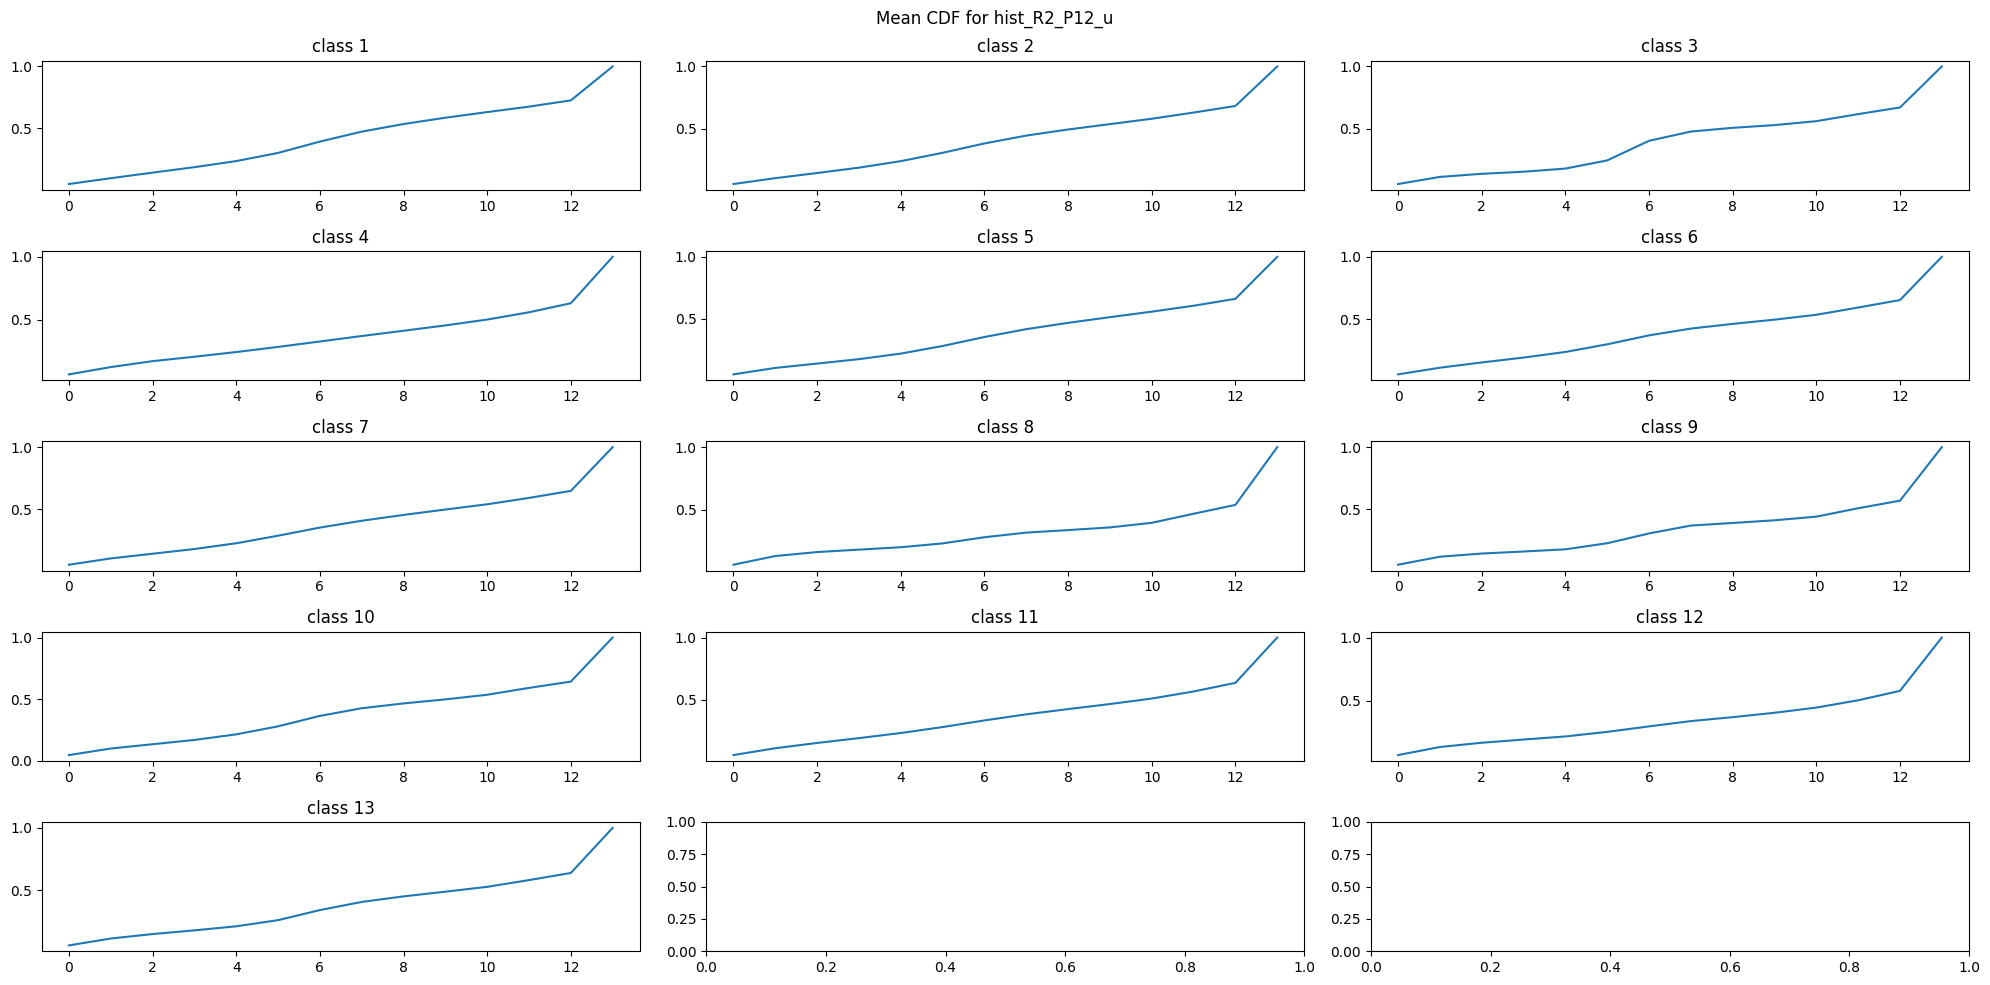

In [17]:
fig, axs = plt.subplots(5, 3)
for k in range(13):
    ax = axs.flat[k]
    ax.plot(range(means_cdf.shape[1]), means_cdf[k], '-')
    ax.set_title(f'class {k+1}')
for k in range(13,len(axs)):
    axs.flat[k].set_axis_off()
fig.suptitle(f'Mean CDF for {descriptor}')
fig.set_size_inches((20,10))
fig.tight_layout()

### Most abundand features

In [18]:
# means_int = means.astype(np.uint32)
sorted_means = np.ascontiguousarray(np.sort(means, axis=1)[:, ::-1]) / (chunksize**2)   # descending order
sorted_means.shape, sorted_means.dtype

((13, 14), dtype('float64'))

In [19]:
sorted_means_cdf = sorted_means.cumsum(axis=1)
sorted_means_cdf.shape, sorted_means_cdf.dtype

((13, 14), dtype('float64'))

In [20]:
sorted_means_cdf.max(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

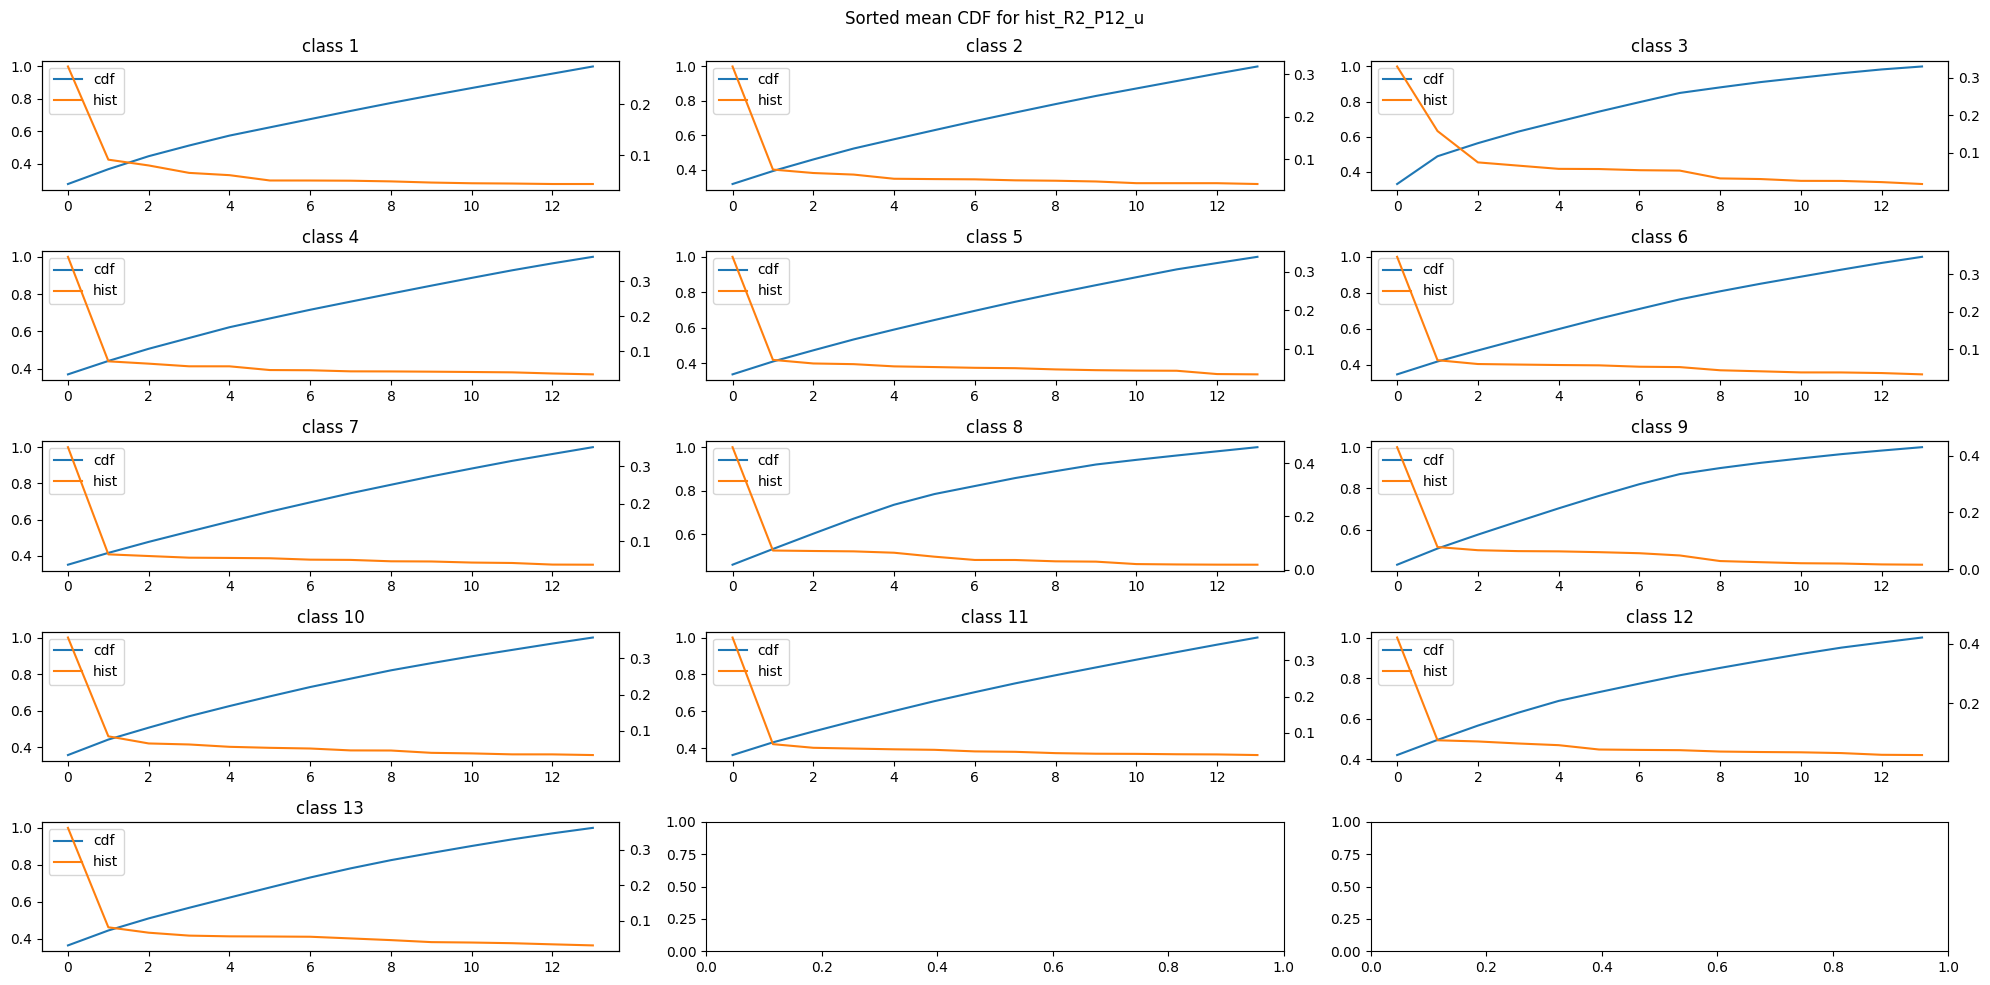

In [21]:
fig, axs = plt.subplots(5, 3)
for k in range(13):
    ax = axs.flat[k]
    a, = ax.plot(range(sorted_means_cdf.shape[1]), sorted_means_cdf[k], '-', color='C0', label='cdf')
    b, = ax.twinx().plot(range(sorted_means_cdf.shape[1]), sorted_means[k], '-', color='C1', label='hist')
    ax.set_title(f'class {k+1}')
    ax.legend(handles=[a,b])
for k in range(13,len(axs)):
    axs.flat[k].set_axis_off()
fig.suptitle(f'Sorted mean CDF for {descriptor}')
fig.set_size_inches((20,10))
fig.tight_layout()

## 2. Normality

In [114]:
# Відхилення кожного спостереження від середнього
delta = np.array([ X_cl[k] - means[k] for k in range(13) ])
delta.shape, delta.dtype

((13, 150, 14), dtype('float64'))

In [115]:
alpha = 0.05
print("Number of likely normal features using D’Agostino, R. and Pearson, E. S. test")
for k in range(13):
    s, pvals = sp.stats.normaltest(delta[k], axis=0)
    res = (pvals > alpha).sum()
    print(f"Class {k+1:2}: {res:3}/{delta.shape[-1]}")

Number of likely normal features using D’Agostino, R. and Pearson, E. S. test
Class  1:   0/14
Class  2:   4/14
Class  3:   2/14
Class  4:   4/14
Class  5:   1/14
Class  6:   3/14
Class  7:   2/14
Class  8:   1/14
Class  9:   8/14
Class 10:   2/14
Class 11:   5/14
Class 12:   5/14
Class 13:   9/14


In [116]:
alpha = 0.05
print("Number of likely normal features using Shapiro-Wilk test")
for k in range(13):
    s, pvals = sp.stats.shapiro(delta[k], axis=0)
    res = (pvals > alpha).sum()
    print(f"Class {k+1:2}: {res:3}/{delta.shape[-1]}")

Number of likely normal features using Shapiro-Wilk test
Class  1:   0/14
Class  2:   4/14
Class  3:   1/14
Class  4:   4/14
Class  5:   1/14
Class  6:   2/14
Class  7:   1/14
Class  8:   0/14
Class  9:   5/14
Class 10:   2/14
Class 11:   4/14
Class 12:   5/14
Class 13:   8/14


## 3. Distribution similarity

### 3.1. Between classes

In [40]:
means_norm = means / (chunksize**2)

In [103]:
# how class j is similar to class i
class_similarity = np.zeros((13,13), dtype=np.float64)
class_similarity_p = np.zeros((13,13), dtype=np.float64)

alpha = 0.05
for c1 in tqdm(range(13)): 
    for c2 in tqdm(range(13), desc="> "):
        if c1 == c2: continue
        stat, pval = sp.stats.power_divergence(f_obs=(means[c2]+1), f_exp=(means[c1]+1), lambda_='log-likelihood')
        class_similarity[c1,c2] = stat
        class_similarity_p[c1,c2] = pval

100%|██████████| 13/13 [00:00<00:00, 134.13it/s]


In [47]:
np.isnan(class_similarity_p).sum()

np.int64(0)

In [45]:
import seaborn as sb

<Axes: >

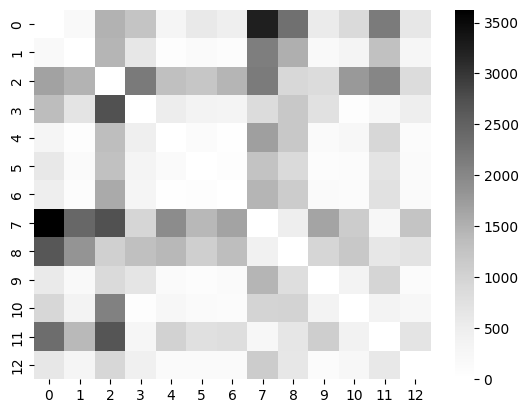

In [104]:
sb.heatmap(class_similarity, cmap='Greys')

In [54]:
class_similarity_p = class_similarity_p.round(6)

Text(0.5, 1.0, 'hist_R2_P12_u\np-value for log-L dist similarity test between classes')

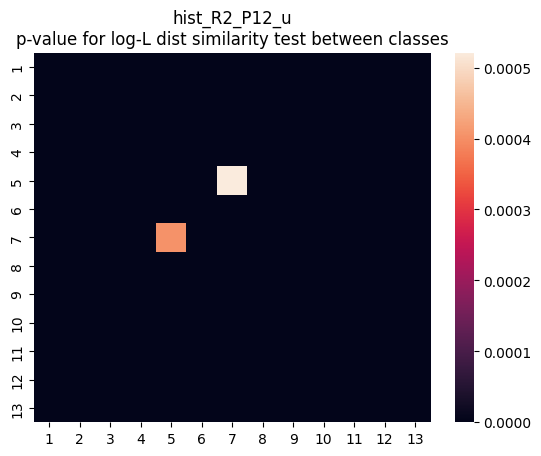

In [58]:
# p_mask = class_similarity_p > alpha
sb.heatmap(class_similarity_p, xticklabels=unique_labels, yticklabels=unique_labels)
plt.title(
    f"{descriptor}\n"
    "p-value for log-L dist similarity test between classes"
)

## 4. Performance

In [124]:
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X, label, test_size=0.4, random_state=25, stratify=label)
X_train.shape, y_train.shape

((1170, 14), (1170,))

In [125]:
unique_labels, label_sizes = np.unique(y_train, return_counts=True)
X_train_cl = np.array([ X_train[y_train == k] for k in unique_labels])
means_train = X_train_cl.mean(axis=1) + 1   # +1 to avoid small values

In [126]:
def predict_naive(x):
    # x should be a non-normed histogram
    distances, pvalues = sp.stats.power_divergence( f_obs=(x+1), f_exp=means_train, axis=1, lambda_='log-likelihood')
    assert len(distances) == len(unique_labels)
    return unique_labels[np.argmin(distances)]

In [127]:
pred_classes = np.zeros_like(y_test)
for i in tqdm(range(y_test.shape[0])):
    pred_classes[i] = predict_naive(X_test[i])


100%|██████████| 780/780 [00:00<00:00, 3427.63it/s]


In [128]:
confusion = skl.metrics.confusion_matrix(y_test, pred_classes, labels=unique_labels)

Text(0.5, 1.0, 'hist_R2_P12_u. Naive argmin-log-L-stat classifier')

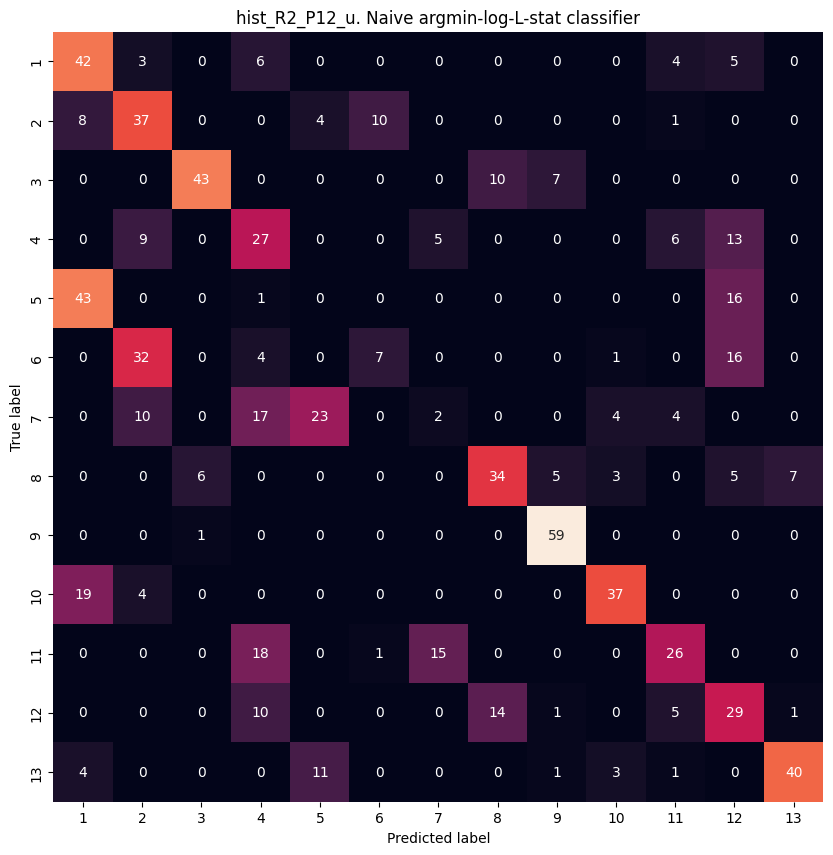

In [129]:
sb.heatmap(confusion, annot=True, fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, square=True, cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label');
plt.gcf().set_size_inches((10,10))
plt.title(f"{descriptor}. Naive argmin-log-L-stat classifier")

In [130]:
print(f"Balanced accuracy score: {skl.metrics.balanced_accuracy_score(y_test, pred_classes):.3f}")
print(f"F1-score[macro]: {skl.metrics.f1_score(y_test, pred_classes, labels=unique_labels, average='macro'):.3f}")
print(f"F1-score[micro]: {skl.metrics.f1_score(y_test, pred_classes, labels=unique_labels, average='micro'):.3f}")

Balanced accuracy score: 0.491
F1-score[macro]: 0.471
F1-score[micro]: 0.491
